## Polynomial Overfitting

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression as SklearnLinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import learning_curve, train_test_split
from sklearn.metrics import mean_squared_error

sns.set_theme(style="whitegrid")
print(f"PyTorch Version: {torch.__version__}")
print(f"NumPy Version: {np.__version__}")
print(f"Scikit-learn Version: {sklearn.__version__}")

torch.manual_seed(42)
np.random.seed(42)

PyTorch Version: 2.3.0+cu118
NumPy Version: 1.24.3
Scikit-learn Version: 1.2.2


### Introduction: Limitations of Simple Linear Models and the Need for Non-Linearity

<p>Simple linear regression assumes a linear relationship between features and the target. What if the true relationship is non-linear? A straight line won't fit well (underfitting).</p>
<p>Polynomial Regression allows us to model non-linear relationships by adding polynomial terms of the original features as new features. Examples: If we have one feature x, we can create x^2, x^3, etc., and fit a linear model to these new features: y = w_0 + w_1*x + w_2*x^2 + w_3*x^3 + ... This is still a linear model in terms of the coefficients w_i, but it can model a non-linear relationship between the original x and y.</p>

In [6]:
# Let's create data with a quadratic or sinusoidal underlying pattern
def true_func(x):
    # eg. a quadratic function with some noise
    return 0.5 * x**2 + x + 2 + torch.randn_like(x) * 1.5
    # Alternative: return torch.sin(1.5 * torch.pi * X) + torch.randn_like(X) * 0.3

In [7]:
NUM_SAMPLES_TOTAL = 100

# Generate X values using PyTorch and sort them for easier plotting later
X_tensor_orig = torch.sort(torch.rand(NUM_SAMPLES_TOTAL, 1) * 10 - 5)[0]  # Values between -5 and 5
y_tensor_orig = true_func(X_tensor_orig)

In [8]:
X_tensor_orig.shape, y_tensor_orig.shape

(torch.Size([100, 1]), torch.Size([100, 1]))

In [55]:
X_train_orig, X_test_orig, y_train, y_test = train_test_split(
    X_tensor_orig, y_tensor_orig, test_size=0.3, random_state=42
)

In [10]:
X_train_orig.shape, X_test_orig.shape

(torch.Size([70, 1]), torch.Size([30, 1]))

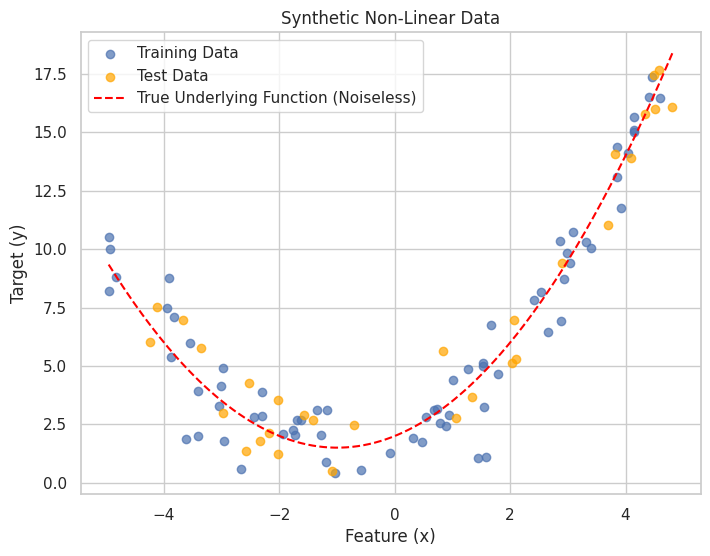

In [11]:
# Visualize the data
plt.figure(figsize=(8, 6))
plt.scatter(X_train_orig.numpy(), y_train.numpy(), alpha=0.7, label='Training Data')
plt.scatter(X_test_orig.numpy(), y_test.numpy(), alpha=0.7, color='orange', label='Test Data')

X_plot_smooth = torch.linspace(X_tensor_orig.min(), X_tensor_orig.max(), 200).reshape(-1, 1)
y_plot_smooth_true = 0.5 * X_plot_smooth**2 + X_plot_smooth + 2  # Noiseless true function

plt.plot(X_plot_smooth.numpy(), y_plot_smooth_true.numpy(), 
         color='red', linestyle='--', label='True Underlying Function (Noiseless)')
plt.xlabel("Feature (x)")
plt.ylabel("Target (y)")
plt.title("Synthetic Non-Linear Data")
plt.legend()
plt.show()

### Simple Linear Regression (Underfitting)

In [12]:
model_linear = nn.Linear(1,1)   # 1 input feature, 1 output feature
criterion = nn.MSELoss()
optimizer = optim.SGD(model_linear.parameters(), lr=0.01)
epochs = 300

In [13]:
for epoch in range(epochs):
    # forward pass
    y_pred_linear = model_linear(X_train_orig)
    # compute loss
    loss_linear = criterion(y_pred_linear, y_train)
    # backward pass and optimize
    optimizer.zero_grad()
    loss_linear.backward()
    optimizer.step()
    if (epoch + 1) % 100 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss_linear.item():.4f}")

Epoch [100/300], Loss: 15.8472
Epoch [200/300], Loss: 15.1187
Epoch [300/300], Loss: 15.1059


In [14]:
# evaluate the linear model
with torch.no_grad():
    y_pred_linear_test = model_linear(X_test_orig)
    mse_linear_test = mean_squared_error(y_test.numpy(), y_pred_linear_test.numpy())
print(f"Simple Linear Model - Test MSE: {mse_linear_test: .4f}")

Simple Linear Model - Test MSE:  14.5578


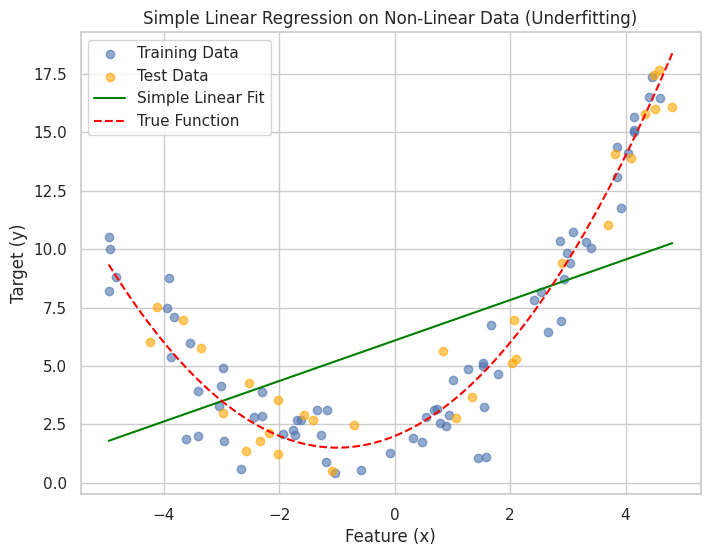

In [17]:
plt.figure(figsize=(8, 6))
plt.scatter(X_train_orig.numpy(), y_train.numpy(), alpha=0.6, label='Training Data')
plt.scatter(X_test_orig.numpy(), y_test.numpy(), alpha=0.6, color='orange', label='Test Data')
with torch.no_grad():
    X_plot_tensor = X_plot_smooth
    y_plot_linear_pred = model_linear(X_plot_tensor).numpy()
plt.plot(X_plot_smooth, y_plot_linear_pred, color="green", label="Simple Linear Fit")
plt.plot(X_plot_smooth, y_plot_smooth_true, color="red", linestyle="--", label="True Function")
plt.xlabel("Feature (x)"); plt.ylabel("Target (y)")
plt.title("Simple Linear Regression on Non-Linear Data (Underfitting)")
plt.legend()
plt.show()

### Polynomial Regression

To fit non-linear data, we can add polynomial features. If X = [x], polynomial features of degree 2 would be [1, x, x^2]. We then fix a linear model to these transformed features.

In [18]:
# creating polynomial features
degree_poly_good = 2    # quadratic fit first, which matches true function
poly_features_good = PolynomialFeatures(degree=degree_poly_good, include_bias=False)    # handling bias in nn.Linear

In [20]:
# transform training and test data
X_train_poly_good_numpy = poly_features_good.fit_transform(X_train_orig.numpy())
X_test_poly_good_numpy = poly_features_good.transform(X_test_orig.numpy())

In [21]:
# Convert back to PyTorch tensors
X_train_poly_good = torch.from_numpy(X_train_poly_good_numpy.astype(np.float32))
X_test_poly_good = torch.from_numpy(X_test_poly_good_numpy.astype(np.float32))

In [23]:
X_train_orig.shape, X_train_poly_good.shape

(torch.Size([70, 1]), torch.Size([70, 2]))

<p>If degree=2, shape will be (num_samples, 2) -> [x, x^2]</p>
If degree=d, shape will be (num_samples, d) -> [x, x^2, ..., x^d]

In [26]:
# Training polynomial regression model (degree 2)
num_poly_features_good = X_train_poly_good.shape[1]
model_poly_good = nn.Linear(num_poly_features_good, 1)
optimizer_poly_good = optim.SGD(model_poly_good.parameters(), lr=0.005)
epochs_poly = 500

In [29]:
model_poly_good

Linear(in_features=2, out_features=1, bias=True)

In [30]:
for epoch in range(epochs_poly):
    y_pred_poly = model_poly_good(X_train_poly_good)
    loss_poly = criterion(y_pred_poly, y_train)
    optimizer_poly_good.zero_grad()
    loss_poly.backward()
    optimizer_poly_good.step()
    if (epoch + 1) % 100 == 0:
        print(f"Epoch [{epoch+1}/{epochs_poly}], Loss: {loss_poly.item():.4f}")

Epoch [100/500], Loss: 2.4153
Epoch [200/500], Loss: 1.9343
Epoch [300/500], Loss: 1.7258
Epoch [400/500], Loss: 1.6354
Epoch [500/500], Loss: 1.5961


In [31]:
# Evaluate
with torch.no_grad():
    y_pred_poly_good_test = model_poly_good(X_test_poly_good)
    mse_poly_good_test = mean_squared_error(y_test.numpy(), y_pred_poly_good_test.numpy())
print(f"Polynomial (Deg {degree_poly_good}) Model - Test MSE: {mse_poly_good_test:.4f}")

Polynomial (Deg 2) Model - Test MSE: 1.4747


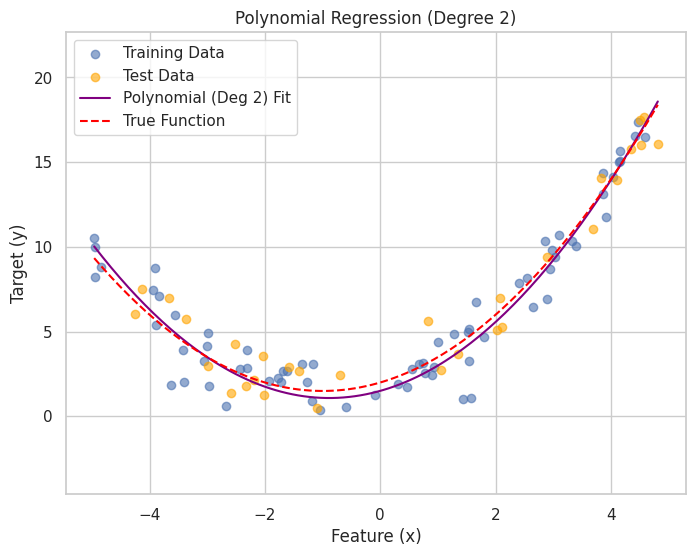

In [34]:
# Plot the fit
plt.figure(figsize=(8, 6))
plt.scatter(X_train_orig.numpy(), y_train.numpy(), alpha=0.6, label='Training Data')
plt.scatter(X_test_orig.numpy(), y_test.numpy(), alpha=0.6, color='orange', label='Test Data')
# For plotting the curve, transform the smooth X_plot_smooth
X_plot_poly_good_numpy = poly_features_good.transform(X_plot_smooth)
X_plot_poly_good_tensor = torch.from_numpy(X_plot_poly_good_numpy.astype(np.float32))
with torch.no_grad():
    y_plot_poly_good_pred = model_poly_good(X_plot_poly_good_tensor).numpy()
plt.plot(X_plot_smooth, y_plot_poly_good_pred, color='purple', label=f'Polynomial (Deg {degree_poly_good}) Fit')
plt.plot(X_plot_smooth, y_plot_smooth_true, color='red', linestyle='--', label='True Function')
plt.xlabel("Feature (x)"); plt.ylabel("Target (y)")
plt.title(f"Polynomial Regression (Degree {degree_poly_good})")
plt.legend(); plt.ylim(y_tensor_orig.numpy().min()-5, y_tensor_orig.numpy().max()+5); plt.show()

### Overfitting with high-degree polynomials

In [56]:
# lets define new sample to visualize overfitting
n_samples = 80
X_train_orig_overfit = torch.linspace(-2, 2, n_samples).reshape(-1, 1)  # Smaller range
noise_level = 0.3

In [57]:
# True function: simple quadratic with some complexity
def true_function(x):
    return 0.5 * x**2 + 0.3 * x + 0.1 * np.sin(10 * x)

In [59]:
y_train_true = true_function(X_train_orig_overfit.numpy().flatten())
y_train_overfit = torch.from_numpy(y_train_true + np.random.normal(0, noise_level, n_samples)).float().reshape(-1, 1)

In [60]:
# Test data
X_test_orig_overfit = torch.linspace(-2.5, 2.5, 50).reshape(-1, 1)  # Slightly broader range
y_test_true = true_function(X_test_orig_overfit.numpy().flatten())
y_test_overfit = torch.from_numpy(y_test_true + np.random.normal(0, noise_level, 50)).float().reshape(-1, 1)

In [61]:
# For plotting smooth curve
X_plot_smooth = np.linspace(-3, 3, 200).reshape(-1, 1)
y_plot_true = true_function(X_plot_smooth.flatten())

In [62]:
X_test_orig_overfit.shape

torch.Size([50, 1])

In [63]:
# --- Comparison of different polynomial degrees ---
degrees_to_compare = [2, 5, 10, 15]
models = {}
results = {}



--- Training Polynomial Degree 2 ---
Epoch [200/1000], Loss: 0.103535
Epoch [400/1000], Loss: 0.103533
Epoch [600/1000], Loss: 0.103533
Epoch [800/1000], Loss: 0.103533
Epoch [1000/1000], Loss: 0.103533
Degree 2 - Train MSE: 0.103533, Test MSE: 0.064710
Overfitting ratio (Test/Train MSE): 0.625

--- Training Polynomial Degree 5 ---
Epoch [200/1000], Loss: 0.103516
Epoch [400/1000], Loss: 0.102768
Epoch [600/1000], Loss: 0.102436
Epoch [800/1000], Loss: 0.102116
Epoch [1000/1000], Loss: 0.101826
Degree 5 - Train MSE: 0.101825, Test MSE: 0.364352
Overfitting ratio (Test/Train MSE): 3.578

--- Training Polynomial Degree 10 ---
Epoch [600/3000], Loss: 0.278818
Epoch [1200/3000], Loss: 0.117657
Epoch [1800/3000], Loss: 0.102714
Epoch [2400/3000], Loss: 0.101641
Epoch [3000/3000], Loss: 0.101130
Degree 10 - Train MSE: 0.101129, Test MSE: 1.187934
Overfitting ratio (Test/Train MSE): 11.747

--- Training Polynomial Degree 15 ---
Epoch [600/3000], Loss: 0.151165
Epoch [1200/3000], Loss: 0.1068

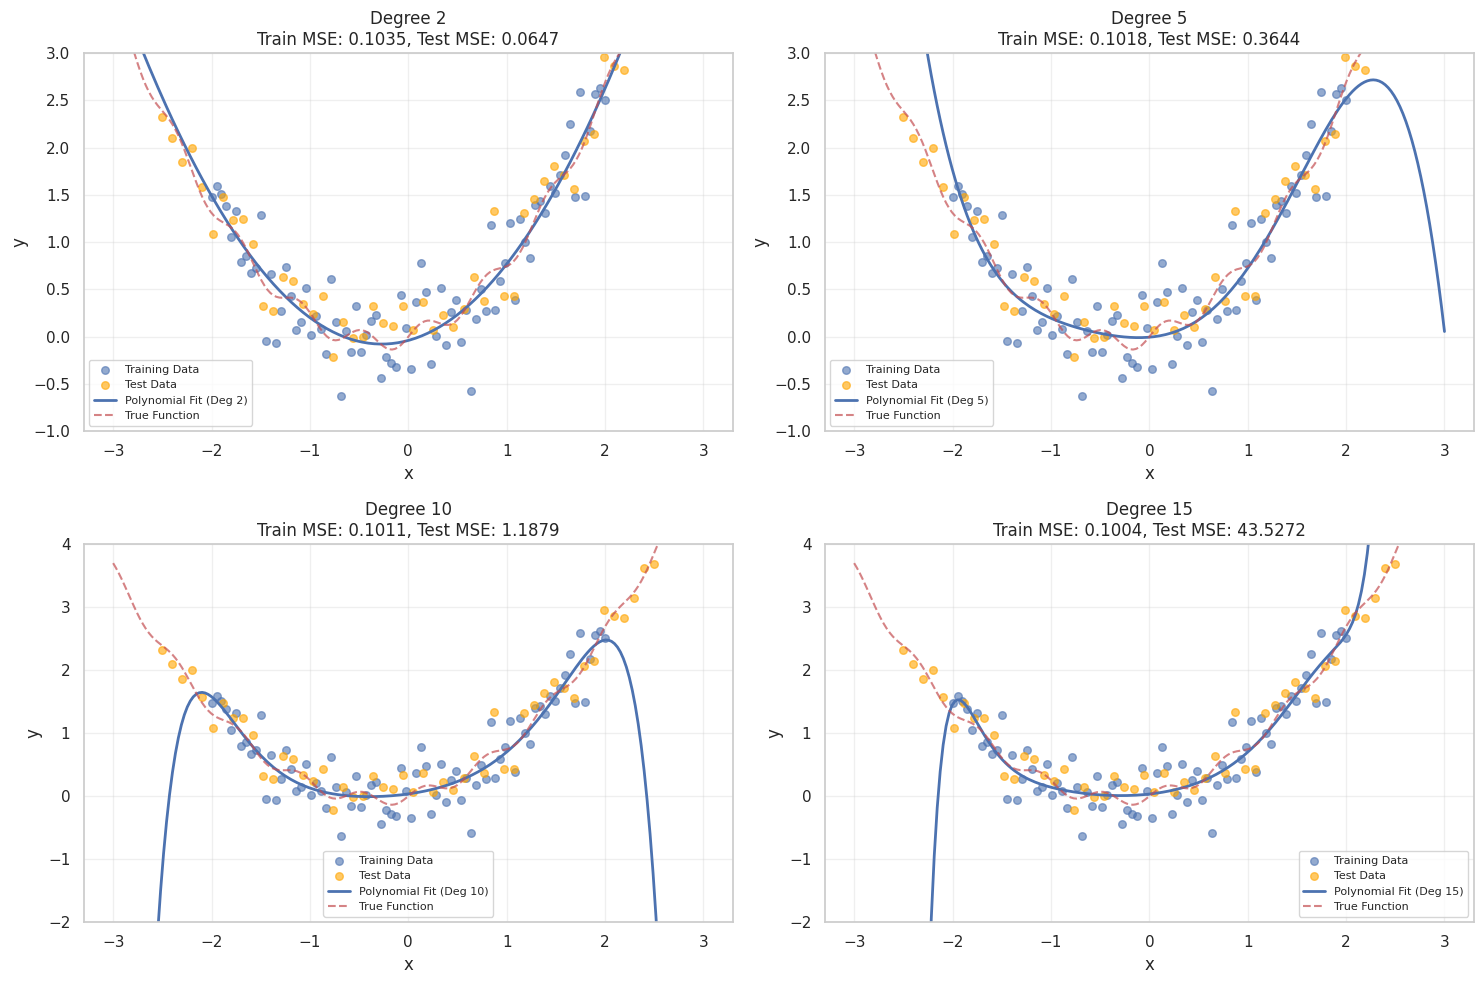

In [66]:
# This code was generated using ClauseSonnet4
plt.figure(figsize=(15, 10))

for idx, degree in enumerate(degrees_to_compare):
    print(f"\n--- Training Polynomial Degree {degree} ---")
    
    # Create polynomial features
    poly_features = PolynomialFeatures(degree=degree, include_bias=False)
    X_train_poly = poly_features.fit_transform(X_train_orig_overfit.numpy())
    X_test_poly = poly_features.transform(X_test_orig_overfit.numpy())
    
    # For high degrees, we need regularization through careful scaling
    if degree > 5:
        # For high degrees, use more conservative scaling
        scaler = StandardScaler()
        X_train_poly = scaler.fit_transform(X_train_poly)
        X_test_poly = scaler.transform(X_test_poly)
    
    # Convert to tensors
    X_train_tensor = torch.from_numpy(X_train_poly.astype(np.float32))
    X_test_tensor = torch.from_numpy(X_test_poly.astype(np.float32))
    
    # Create model
    model = nn.Linear(X_train_tensor.shape[1], 1)
    
    # Adjust learning rate based on degree
    if degree <= 5:
        lr = 0.01
        epochs = 1000
    else:
        lr = 0.001  # Smaller learning rate for high degrees
        epochs = 3000
    
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-6)  # Small weight decay
    criterion = nn.MSELoss()
    
    # Training
    for epoch in range(epochs):
        y_pred = model(X_train_tensor)
        loss = criterion(y_pred, y_train_overfit)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (epoch + 1) % (epochs // 5) == 0:
            print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.6f}")
    
    # Evaluate
    with torch.no_grad():
        y_pred_train = model(X_train_tensor)
        train_mse = mean_squared_error(y_train_overfit.numpy(), y_pred_train.numpy())
        
        y_pred_test = model(X_test_tensor)
        test_mse = mean_squared_error(y_test_overfit.numpy(), y_pred_test.numpy())
    
    print(f"Degree {degree} - Train MSE: {train_mse:.6f}, Test MSE: {test_mse:.6f}")
    print(f"Overfitting ratio (Test/Train MSE): {test_mse/train_mse:.3f}")
    
    # Store results
    models[degree] = model
    results[degree] = {
        'train_mse': train_mse,
        'test_mse': test_mse,
        'poly_features': poly_features,
        'scaler': scaler if degree > 5 else None
    }
    
    # Plot
    plt.subplot(2, 2, idx + 1)
    plt.scatter(X_train_orig_overfit.numpy(), y_train_overfit.numpy(), alpha=0.6, s=30, label='Training Data')
    plt.scatter(X_test_orig_overfit.numpy(), y_test_overfit.numpy(), alpha=0.6, s=30, color='orange', label='Test Data')
    
    # Plot prediction curve
    X_plot_poly = poly_features.transform(X_plot_smooth)
    if degree > 5 and results[degree]['scaler']:
        X_plot_poly = results[degree]['scaler'].transform(X_plot_poly)
    
    X_plot_tensor = torch.from_numpy(X_plot_poly.astype(np.float32))
    
    with torch.no_grad():
        y_plot_pred = model(X_plot_tensor).numpy()
    
    plt.plot(X_plot_smooth, y_plot_pred, linewidth=2, 
             label=f'Polynomial Fit (Deg {degree})')
    plt.plot(X_plot_smooth, y_plot_true, 'r--', alpha=0.7, label='True Function')
    
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title(f'Degree {degree}\nTrain MSE: {train_mse:.4f}, Test MSE: {test_mse:.4f}')
    plt.legend(fontsize=8)
    plt.grid(True, alpha=0.3)
    
    # Set reasonable y-limits to show overfitting oscillations
    if degree >= 10:
        plt.ylim(-2, 4)
    else:
        plt.ylim(-1, 3)

plt.tight_layout()
plt.show()

In [67]:
# Summary comparison
print("\n=== OVERFITTING SUMMARY ===")
print("Degree | Train MSE | Test MSE  | Overfitting Ratio")
print("-------|-----------|-----------|------------------")
for degree in degrees_to_compare:
    train_mse = results[degree]['train_mse']
    test_mse = results[degree]['test_mse']
    ratio = test_mse / train_mse
    print(f"  {degree:2d}   |  {train_mse:.6f} | {test_mse:.6f} |      {ratio:.3f}")

print("\nObservations:")
print("- Low degrees: Similar train/test MSE (good generalization)")
print("- High degrees: Low train MSE, high test MSE (overfitting)")
print("- Overfitting ratio > 2.0 indicates significant overfitting")


=== OVERFITTING SUMMARY ===
Degree | Train MSE | Test MSE  | Overfitting Ratio
-------|-----------|-----------|------------------
   2   |  0.103533 | 0.064710 |      0.625
   5   |  0.101825 | 0.364352 |      3.578
  10   |  0.101129 | 1.187934 |      11.747
  15   |  0.100412 | 43.527199 |      433.488

Observations:
- Low degrees: Similar train/test MSE (good generalization)
- High degrees: Low train MSE, high test MSE (overfitting)
- Overfitting ratio > 2.0 indicates significant overfitting


### Bias-Variance Tradeoff

- ##### Bias: Error from erroneous assumptions in the learning algorithm. High bias can cause
  <p>an algorithm to miss relevant relations between features and target (underfitting). Example: Simple linear model on non-linear data.</p>
- ##### Variance: Error from sensitivity to small fluctuations in the training set. High variance
  <p>can cause an algorithm to model the random noise in the training data (overfitting). Example: High-degree polynomial model.</p>

##### Goal: Find a model with low bias AND low variance. This is a tradeoff.
- Simple models (e.g., linear): High bias, low variance.
- Complex models (e.g., high-degree poly): Low bias (on training), high variance.

##### The Test MSE can be decomposed (conceptually):
<p>E[(y - h(x))^2] = Bias[h(x)]^2 + Var[h(x)] + σ^2 (irreducible error)</p>

##### Our models:
1. Simple Linear: High Bias (underfits), Low Variance.
2. Polynomial (Degree 2): Lower Bias (good fit), Moderate Variance.
3. Polynomial (Degree 15): Very Low Bias (on training), Very High Variance (overfits).

### Learning Curves

<p>Learning curves plot the training error and validation (or test) error as a function of the training set size (or number of epochs, but training set size is more standard for this diagnosis). They are useful tool to diagnose if a model is suggering from high ias or high variance.</p>

In [68]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.
    (Adapted from scikit-learn documentation)
    """
    plt.figure(figsize=(8,6))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Negative MSE Score (higher is better for sklearn's score)") # sklearn uses 'score', often -MSE

    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes,
        scoring="neg_mean_squared_error") # Use negative MSE as score

    train_scores_mean = -np.mean(train_scores, axis=1) # Invert to get positive MSE
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = -np.mean(test_scores, axis=1)   # Invert to get positive MSE
    test_scores_std = np.std(test_scores, axis=1)

    plt.grid(True)
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score (MSE)")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score (MSE)")
    plt.ylabel("Mean Squared Error") # Changed label to reflect positive MSE
    plt.legend(loc="best")
    return plt

In [70]:
X_lc, y_lc = X_tensor_orig.numpy(), y_tensor_orig.numpy().ravel() # y needs to be 1D for sklearn's learning_curve

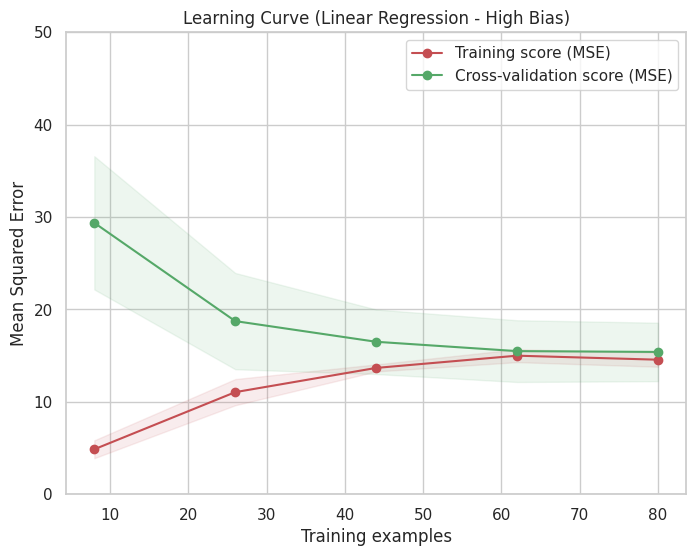

In [71]:
# Model 1: Simple Linear Regression (High Bias candidate)
estimator_linear_lc = make_pipeline(StandardScaler(), SklearnLinearRegression())
plot_learning_curve(estimator_linear_lc, "Learning Curve (Linear Regression - High Bias)",
                    X_lc, y_lc, cv=5, ylim=(0, 50)) # Adjust ylim as needed
plt.show()
# Expected: Both training and validation error converge to a high value. Small gap.

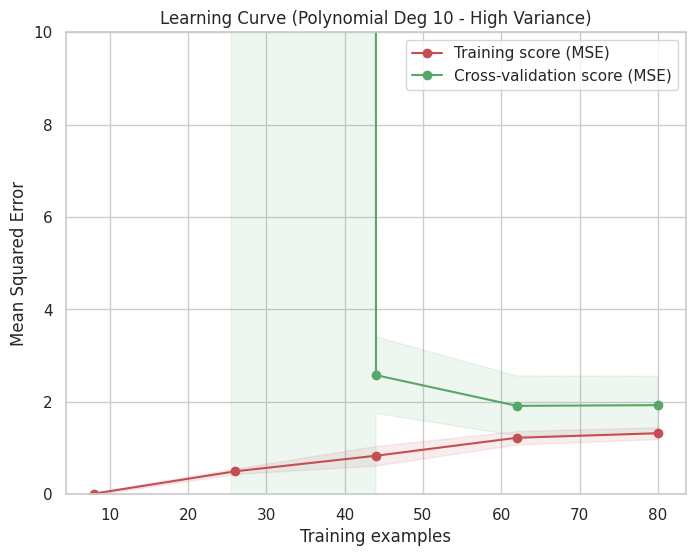

In [80]:
# Model 2: High-Degree Polynomial Regression (High Variance candidate)
degree_lc_overfit = 10 # Slightly less extreme than 15 for clearer learning curve
estimator_poly_lc_overfit = make_pipeline(
    PolynomialFeatures(degree=degree_lc_overfit, include_bias=False),
    StandardScaler(),
    SklearnLinearRegression()
)
plot_learning_curve(estimator_poly_lc_overfit, f"Learning Curve (Polynomial Deg {degree_lc_overfit} - High Variance)",
                    X_lc, y_lc, cv=5, ylim=(0, 10)) 
plt.show()
# Expected: Large gap between training and validation error. Training error low, validation error high.
# Validation error might decrease initially but then plateau or even increase.

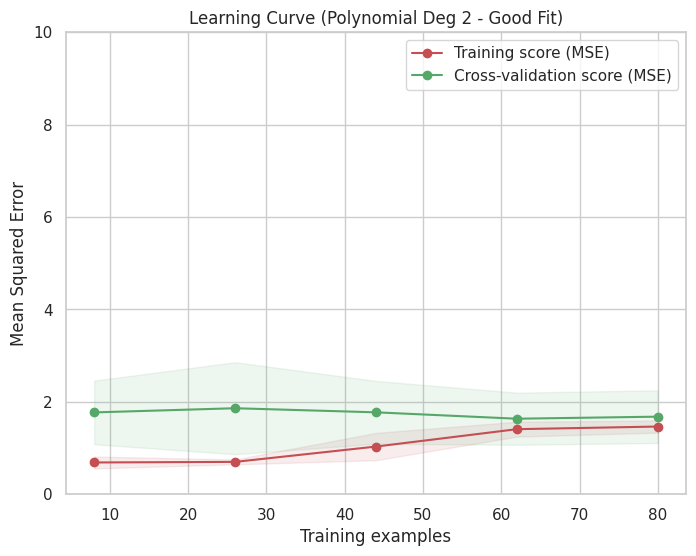

In [82]:
# Model 3: "Just Right" Polynomial Regression
degree_lc_good = 2
estimator_poly_lc_good = make_pipeline(
    PolynomialFeatures(degree=degree_lc_good, include_bias=False),
    StandardScaler(),
    SklearnLinearRegression()
)
plot_learning_curve(estimator_poly_lc_good, f"Learning Curve (Polynomial Deg {degree_lc_good} - Good Fit)",
                    X_lc, y_lc, cv=5, ylim=(0, 10)) # Adjust ylim
plt.show()
# Expected: Both errors converge to a low value. Small gap.

#### Conclusion
- Linear models can underfit if the underlying data relationship is non-linear (high bias).
- Polynomial regression can model non-linear relationships by adding polynomial terms as features.
- High-degree polynomials can overfit the training data, capturing noise and leading to
  poor generalization on unseen data (high variance).
- The Bias-Variance Tradeoff describes the balance between model simplicity (bias) and
  model complexity (variance).
- Learning curves are a diagnostic tool:
  - High Bias: Training and validation scores converge to a poor value.
  - High Variance: Large gap between training and validation scores.